# Predicting the area burnt by forest fires in the northeast region of Portugal
### Course Assignment for ECON F241: Econometric Methods

## Objective

We will be creating a model to _predict the burned area of forest fires, in the northeast region of Portugal, by using meteorological and other data_.

Our aim is to predict the burned area (area) of forest fires. Based on the the spatial, temporal, and weather variables where the fire is spotted. This prediction can be used for calculating the forces sent to the incident and deciding the urgency of the situation.

#### Given variables

1. `FFMC` - FFMC index from the FWI system 
2. `DMC` - DMC index from the FWI system
3. `DC` - DC index from the FWI system
4. `ISI` - ISI index from the FWI system
5. `temp` - temperature in Celsius degrees 
6. `RH` - relative humidity in %
7. `wind` - wind speed in $km/h$
8. `rain` - outside rain in $mm$/$m^2$
9. `area` - the burned area of the forest (in ha)

### Model Notation and Assumptions

<img src="https://miro.medium.com/max/538/1*9i8CucipNQCVMM1d2nSYwQ.jpeg" />
where
<img src="https://miro.medium.com/max/700/1*Q3OpNCxNkOEWEJWH0y52yQ.jpeg" />

In order to “fit” a linear regression model, we establish certain assumptions about the random error that would ensure that we have a good approximation of the actual phenomena once these assumptions are applicable.
These assumptions are as follows:

<img src="https://miro.medium.com/max/700/1*33ygFMRN6ZdD-H71_E_4_Q.jpeg" />

In [1]:
# Defining the variable to be predicted
target = 'area'

In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import statsmodels.api as sm
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from scipy.stats import zscore
from statsmodels.stats.stattools import durbin_watson
# from sklearn.model_selection import train_test_split,KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
# from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings(action='ignore', message='^internal gelsd')

## Load and describe data

In [3]:
# File is stored in dataset directory named 'forestfires.csv'
path = "../dataset/forestfires.csv"
df = pd.read_csv(path)

df.shape

(517, 9)

In [4]:
df.dtypes

FFMC (FFMC index from the FWI system)         float64
DMC (DMC index from the FWI system)           float64
DC ( DC index from the FWI system)            float64
ISI ( ISI index from the FWI system)          float64
temp (in degrees celsius)                     float64
RH (relative humidity in %)                     int64
wind (wind speed in kmph)                     float64
rain (outside rain in mm per square metre)    float64
area (burnt area of the forest in hectare)    float64
dtype: object

In [5]:
# Renaming the column names for our ease
df.rename(columns={'FFMC (FFMC index from the FWI system)': 'FFMC', 'DMC (DMC index from the FWI system)': 'DMC', 'DC ( DC index from the FWI system)':'DC','ISI ( ISI index from the FWI system)':'ISI', 'temp (in degrees celsius)':'temp','RH (relative humidity in %)':'RH', 'wind (wind speed in kmph)':'wind', 'rain (outside rain in mm per square metre)':'rain', 'area (burnt area of the forest in hectare)':'area'  }, inplace=True)

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind,517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain,517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40
area,517.0,12.847292,63.655818,0.0,0.0,0.52,6.57,1090.84


**KEY INFERENCE:** We can see that columns `DMC`, `ISI`, `RH`, `wind`, `rain` and `area` have higher mean value than median, which means that the data is **right skewed**. 

In [7]:
# Checking if there are any missing values
print("No. of missing values =",df.isna().sum().sum())

No. of missing values = 0


In [8]:
plt.rcParams["figure.figsize"] = 9,5

### Univariate analysis

Skew: 12.846933533934868
Kurtosis: 194.1407210942299


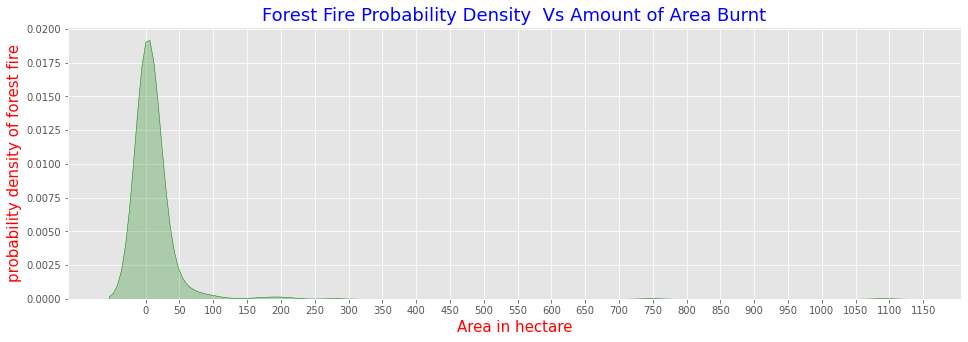

In [9]:
# Let's begin with target variable, 'area'
plt.figure(figsize=(16,5))
print("Skew: {}".format(df[target].skew()))
print("Kurtosis: {}".format(df[target].kurtosis()))
ax = sns.kdeplot(df[target],shade=True,color='g')
plt.xlabel('Area in hectare',color='red',fontsize=15)
plt.ylabel('probability density of forest fire',color='red',fontsize=15)
plt.title('Forest Fire Probability Density  Vs Amount of Area Burnt',color='blue',fontsize=18)
plt.xticks([i for i in range(0,1200,50)])
plt.show()

/home/thedhruvrawat/anaconda3/envs/dl/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


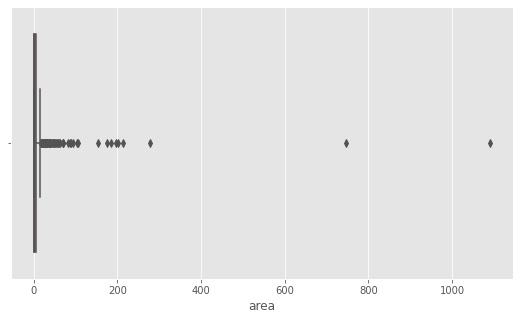

In [10]:
ax = sns.boxplot(df[target])

__KEY INFERENCES:__

- The data is __highly skewed__ with a value of __+12.84__ and __huge kurtosis__ value of __194.14__.

- majority of the forest fires do not cover a large area. most of the damaged area is under 50 hectares of land.

- We can apply tranformation to fix the skewnesss and kurtosis. 

In [11]:
# Identifying outlier points using z-score method
y_outliers = df[abs(zscore(df[target])) >= 3 ]
y_outliers

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
237,91.0,129.5,692.6,7.0,18.8,40,2.2,0.0,212.88
238,92.5,121.1,674.4,8.6,25.1,27,4.0,0.0,1090.84
415,94.8,222.4,698.6,13.9,27.5,27,4.9,0.0,746.28
479,89.2,103.9,431.6,6.4,22.6,57,4.9,0.0,278.53


### Independent columns

In [12]:
dfa = df.drop(columns=target)
num_columns = dfa.columns.tolist()

num_columns

['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']

/home/thedhruvrawat/anaconda3/envs/dl/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:395: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if ax.is_last_row():
/home/thedhruvrawat/anaconda3/envs/dl/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:395: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if ax.is_last_row():
/home/thedhruvrawat/anaconda3/envs/dl/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:395: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if ax.is_last_row():
/home/thedhruvrawat/anaconda3/envs/dl/lib/python3.7/site-p

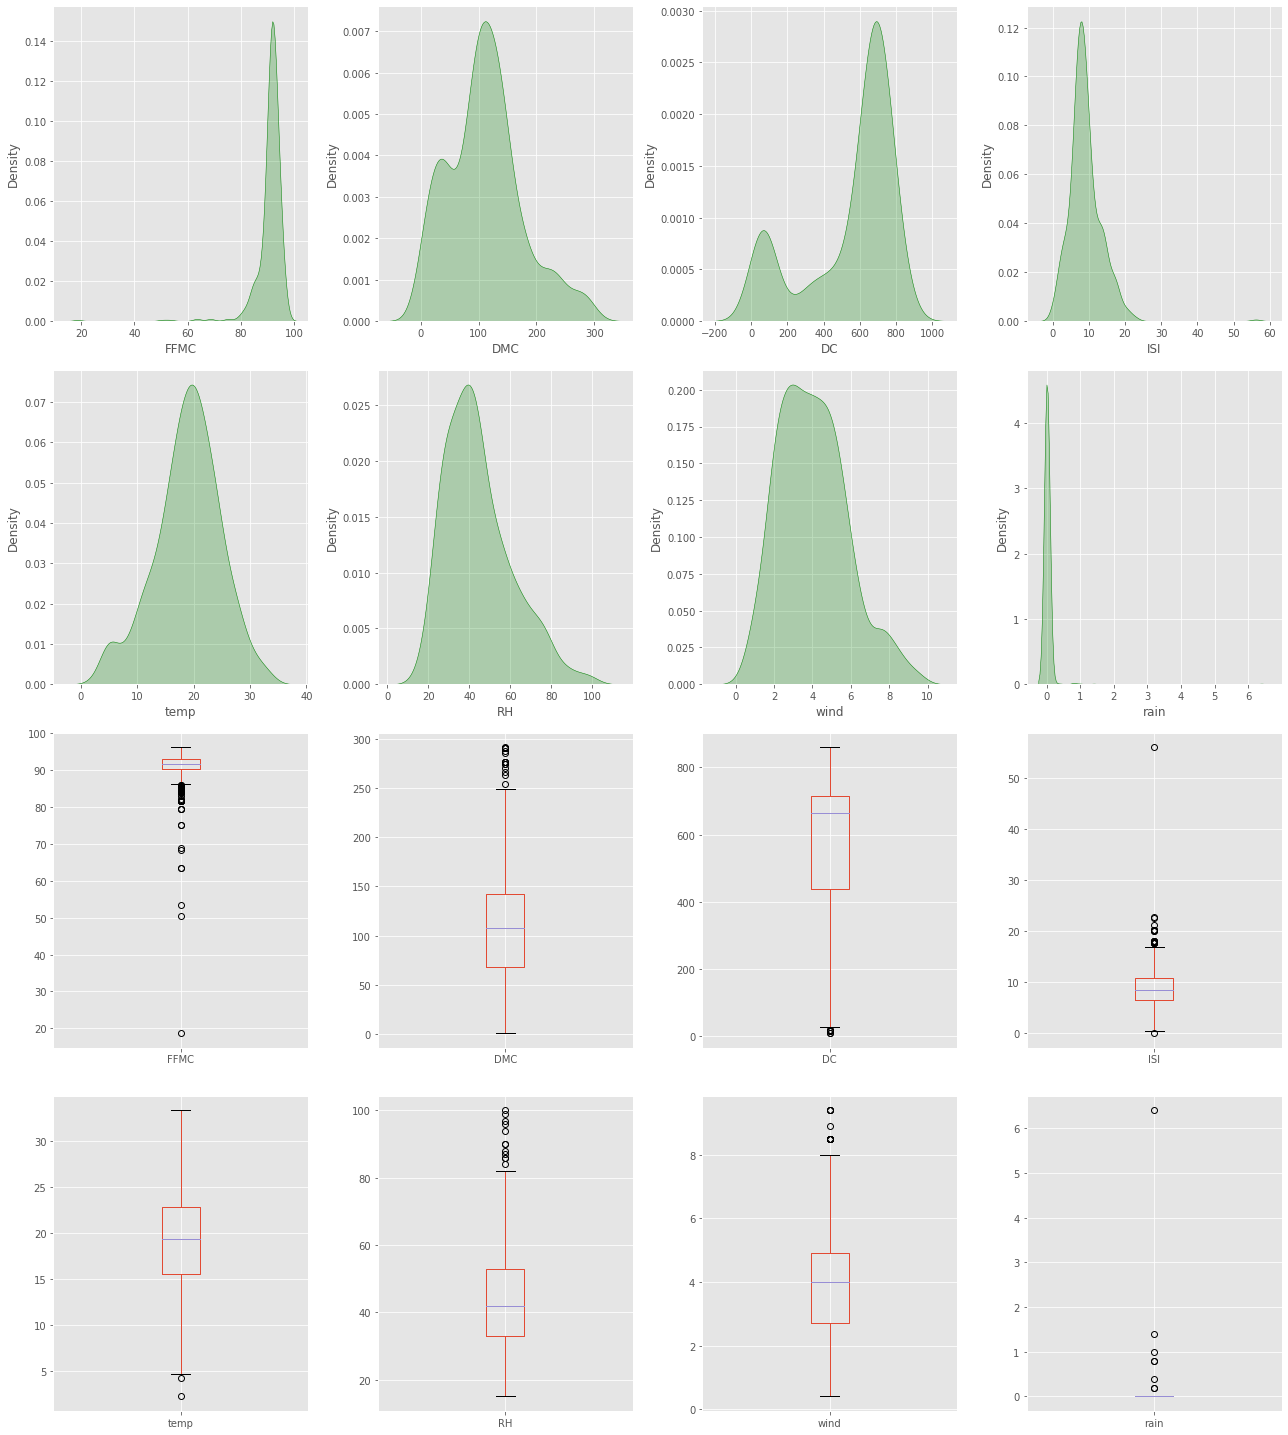

,FFMC,DMC,DC,ISI,temp,RH,wind,rain
skewness,-6.575606,0.547498,-1.100445,2.536325,-0.331172,0.862904,0.571001,19.816344
kurtosis,67.066041,0.204822,-0.245244,21.458037,0.136166,0.438183,0.054324,421.295964


In [13]:
# Exploratory data analysis of our feature columns
plt.figure(figsize=(18,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(8,4,i)
    sns.kdeplot(df[col],color='g',shade=True)
    plt.subplot(8,4,i+8)
    df[col].plot.box()
plt.tight_layout() 
plt.show()
num_data = df[num_columns]
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])

Now, we know that **skew is the degree of distortion from a normal distribution**. 

_Kurtosis_ is used to describe the extreme values in one tail versus the other. It is a __measure of outliers present__ in the distribution . High kurtosis in a data set is an indicator that data has heavy tails or outliers.

If skewness is positive, the data are positively skewed or skewed right, meaning that the right tail of the distribution is longer than the left. 

If skewness is negative, the data are negatively skewed or skewed left, meaning that the left tail is longer.

Numerically, for skewness

- If skewness is less than −1 or greater than +1, the distribution is highly skewed.
- If skewness is between −1 and −½ or between +½ and +1, the distribution is moderately skewed.
- If skewness is between −½ and +½, the distribution is approximately symmetric.

And for kurtosis

- A normal distribution has kurtosis exactly 3 (excess kurtosis exactly 0). Any distribution with kurtosis ≈3 is called mesokurtic.
- A distribution with kurtosis < 3 is called platykurtic. Compared to a normal distribution, its tails are shorter and thinner, and often its central peak is lower and broader.
- A distribution with kurtosis > 3 is called leptokurtic. Compared to a normal distribution, its tails are longer and fatter, and often its central peak is higher and sharper.

__KEY INFERENCES:__

- `ISI` & `rain` have +ve skewness, value more than +1 so, they are right skewed.

- `FFMC` & `temp` have -ve skewness, value less than -1 so, they are left skewed.

- `FFMC`, `ISI` & `rain` have high kurtosis value. This means they have outliers.

Thus columns having both high skewness, kurtosis along with outliers are: `FFMC`, `ISI`, and `rain`

Hence we need to transform them.

#### Outlier treatment

We had observed outliers in `area`, `FFMC`, `ISI` and `rain`

In [14]:
out_columns = ['area','FFMC','ISI','rain']

However, the above outliers are not error values so we cannot remove it.

In order to minimize the effect of outliers in our model we will transform the above features.

#### Ref: https://humansofdata.atlan.com/2018/03/when-delete-outliers-dataset/

### Preparing the data for modelling

We'll use log-transformation in order to reduce the skewness of our data columns. The log transformation is generally used to make highly skewed distributions less skewed. This can be valuable both for making patterns in the data more interpretable and for helping to meet the assumptions of inferential statistics.

#### Ref: https://onlinestatbook.com/2/transformations/log.html

__NOTE:__ Since most of the values in the to-be transformed columns are 0, and taking a log(0) would be absurd, we have added 1 to all the data points. Hence, for a variable $X$ we have applied the transformation $log(X+1)$

In [15]:
# Data transformation
# We'll be using logarithmic transformation
print(df[out_columns].describe())
np.log1p(df[out_columns]).skew(), np.log1p(df[out_columns]).kurtosis() #log1p is inbuilt function in numpy library

              area        FFMC         ISI        rain
count   517.000000  517.000000  517.000000  517.000000
mean     12.847292   90.644681    9.021663    0.021663
std      63.655818    5.520111    4.559477    0.295959
min       0.000000   18.700000    0.000000    0.000000
25%       0.000000   90.200000    6.500000    0.000000
50%       0.520000   91.600000    8.400000    0.000000
75%       6.570000   92.900000   10.800000    0.000000
max    1090.840000   96.200000   56.100000    6.400000


(area     1.217838
 FFMC   -11.675394
 ISI     -0.937218
 rain    14.173028
 dtype: float64,
 area      0.945668
 FFMC    185.482383
 ISI       2.584588
 rain    234.240025
 dtype: float64)

In [16]:
# FFMC and rain are still having high skew and kurtosis values, 
# since we will be using Linear regression model we cannot operate with such high values
# so for FFMC we can remove the outliers in them using z-score method
mask = df.loc[:,['FFMC']].apply(zscore).abs() < 3
df = df[mask.values]

df.shape

(510, 9)

In [17]:
# out_columns.remove('rain')
df[out_columns] = np.log1p(df[out_columns])

In [18]:
df[out_columns].skew(), df[out_columns].kurtosis()

(area     1.208492
 FFMC    -1.803993
 ISI     -0.434372
 rain    14.076080
 dtype: float64,
 area      0.923414
 FFMC      4.866747
 ISI       1.122574
 rain    231.044213
 dtype: float64)

## Multiple Linear Regression

In [19]:
X = df.drop(columns=['area'])
y = df['area']

In [20]:
X_constant = sm.add_constant(X)

# Build OLS model
lin_reg = sm.OLS(y,X_constant).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   area   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.265
Date:                Fri, 30 Apr 2021   Prob (F-statistic):              0.260
Time:                        04:06:39   Log-Likelihood:                -890.18
No. Observations:                 510   AIC:                             1798.
Df Residuals:                     501   BIC:                             1836.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.2425     16.661      0.675      0.500     -21.491      43.976
FFMC          -2.2901      3.789     -0.604      0.546      -9.735       5.155
DMC            0.0015      0.001      0.994      0.321      -0.001       0.004
DC             0.0003      0.000      0.908      0.364      -0.000       0.001
ISI           -0.1644      0.276     -0.596      0.552      -0.707       0.378
temp           0.0084      0.018      0.477      0.634      -0.026       0.043
RH            -0.0050      0.005     -0.928      0.354      -0.015       0.006
wind           0.0784      0.038      2.074      0.039       0.004       0.153
rain          -0.0532      0.591     -0.090      0.928      -1.215       1.109
==============================================================================
Omnibus:                       87.471   Durbin-Watson:                   0.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              129.919
Skew:                           1.168   Prob(JB):                     6.14e-29
Kurtosis:                       3.812   Cond. No.                     1.70e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.7e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Statistical Tests

### 1. Homoscedasticity

Homoscedacity: If the residuals are symmetrically distributed across the trend , then it is called as homoscedacious.

Heteroscedacity: If the residuals are not symmetric across the trend, then it is called as heteroscedacious.

#### Goldfeld-Quandt test for Homoscedasticity

__Null hypothesis, $H_0$__ - Constant variance among residuals (Homoscedacity)

__Alternate hypothesis, $H_1$__ - Heteroscedacity.

In [21]:
sms.het_goldfeldquandt(lin_reg.resid, lin_reg.model.exog)

(0.888204171994489, 0.8234271013775512, 'increasing')

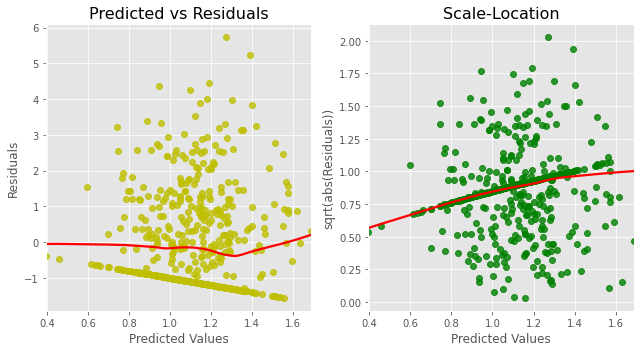

In [22]:
model = lin_reg
fitted_vals = model.predict()
resids = model.resid
resids_standardized = model.get_influence().resid_studentized_internal

fig, ax = plt.subplots(1,2)

sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], color='y', line_kws={'color': 'red'})
ax[0].set_title('Predicted vs Residuals', fontsize=16)
ax[0].set(xlabel='Predicted Values', ylabel='Residuals')

sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], color='g', line_kws={'color': 'red'})
ax[1].set_title('Scale-Location', fontsize=16)
ax[1].set(xlabel='Predicted Values', ylabel='sqrt(abs(Residuals))')

plt.tight_layout()

In [23]:
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model.resid, model.model.exog)
lzip(name, test)

[('F statistic', 0.888204171994489), ('p-value', 0.8234271013775512)]

__KEY INFERENCES:__
- To identify homoscedasticity in the plots, the placement of the points should be equally distributed, random, no pattern (increase/decrease in values of residuals) should be visible and a flat red line.
- In the plots we can see there are no paticular patterns and P-Values is also greater than 0.05 ,so we can say that there is homoscedasticity.
- Outliers can make it Heteroscedacious, Transforming (log or Box cox, if > 0) the dependent or independent variables can help fix it.

#### Breusch-Pagan test

In [24]:
import statsmodels.stats.api as sms

#perform Bresuch-Pagan test
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(lin_reg.resid, lin_reg.model.exog)

lzip(names, test)

[('Lagrange multiplier statistic', 10.108686994254404),
 ('p-value', 0.2574802611370161),
 ('f-value', 1.2663883259117688),
 ('f p-value', 0.25877322486814247)]

A Breusch-Pagan test uses the following null and alternative hypotheses:

__Null hypothesis, $H_0$__: Homoscedasticity is present.

__Alternative hypothesis, $H_1$__: Homoscedasticity is not present (i.e. heteroscedasticity exists)

Here, the Lagrange multiplier statistic for the test is 10.1087 and the corresponding p-value is 0.257. Because this p-value is not less than 0.05, we __fail to reject the null hypothesis__. We do not have sufficient evidence to say that heteroscedasticity is present in the regression model.

### 2. Autocorrelation

Autocorrelation measures the relationship between a variable's current value and its past values.

#### Durbin- Watson Test

It's test statistic value ranges from 0-4. If the value is between

- 0-2, it's known as Positive Autocorrelation.
- 2-4, it is known as Negative autocorrelation.
- exactly 2, it means No Autocorrelation.

For a good linear model, it should have low or no autocorrelation.

In [25]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(lin_reg.resid)

0.9240917048616472

/home/thedhruvrawat/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


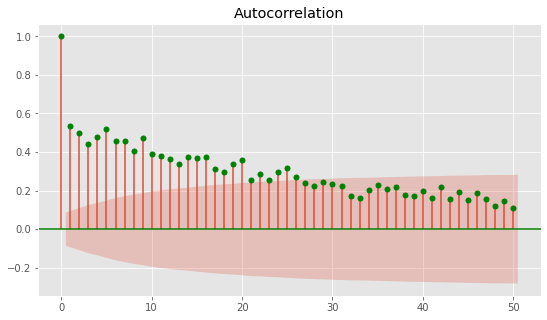

In [26]:
import statsmodels.tsa.api as smt
# Confidence intervals are drawn as a cone. 
# By default, this is set to a 95% confidence interval, 
# suggesting that correlation values outside of this code are very likely a correlation 
# and not a statistical fluke
acf = smt.graphics.plot_acf(lin_reg.resid, color='g', lags=50 , alpha=0.05)
acf.show()


__KEY INFERENCES:__
- By observing the above data we can say that there is positive autocorrelation is present , we can reduce it by using fine tuning our parameters
- We can even use Generalize Least Squares (GLS) model

### 3. Multicollinearity

Multicollineariy arises when one independent variable can be linearly predicted by others with a substantial level of accuracy.

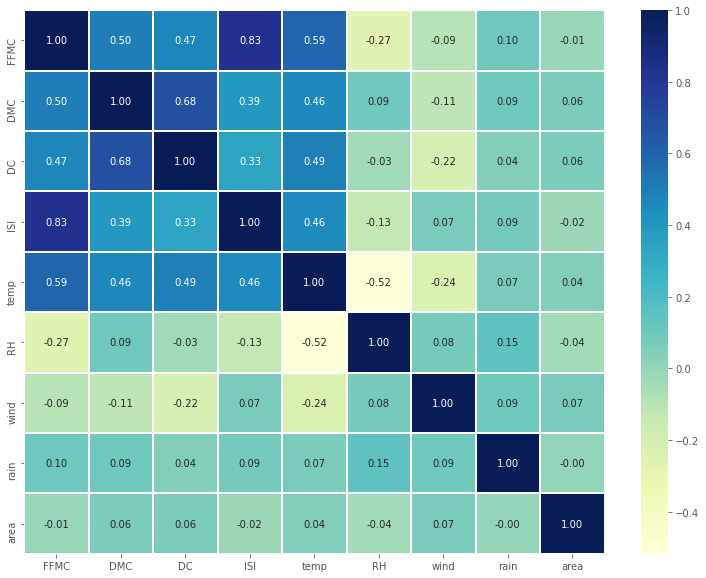

In [27]:
plt.figure(figsize =(13,10))

sns.heatmap(df.corr(),annot=True,cmap='YlGnBu',linewidth = 0.05,fmt=".2f",cbar=True)
plt.show()

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=X.columns).sort_values(by="vif",ascending=False)

,vif
FFMC,4.571691
ISI,3.647552
temp,2.694214
DMC,2.356285
DC,2.107447
RH,1.903550
wind,1.189855
rain,1.084436


There is no significant multicollinearity present since vif<5 for all.

- We can even use PCA to reduce features to a smaller set of uncorrelated components.
- To deal with multicollinearity we should iteratively remove features with high values of VIF.

## Final Model:

$ln(area+1) =  \beta_{0}+\beta_{1}ln(FFMC+1)+\beta_{2}(DMC)+\beta_{3}(DC)+\beta_{4}ln(ISI+1)+\beta_{5}(temp)+\beta_{6}(RH)+\beta_{7}(wind)+\beta_{8}ln(rain+1)+\epsilon$

## References
https://www.kaggle.com/psvishnu/forestfire-impact-prediction-stats-and-ml